In [1]:
import os.path as op
import numpy as np
import mne
from mne.datasets import sample
mne.set_log_level('WARNING')

In [2]:
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

In [4]:
data_path = sample.data_path()

raw_fname = op.join(data_path, 'MEG', 'sample',
                    'sample_audvis_filt-0-40_raw.fif')

raw = mne.io.read_raw_fif(raw_fname, preload=False)

In [5]:
events = mne.find_events(raw, stim_channel='STI 014')
tmin, tmax = -.2, .5
baseline = (None, 0)
event_id = {'aud/left': 1,
            'aud/right': 2,
            'vis/left': 3,
            'vis/right': 4}
reject = dict(grad=4000e-13, mag=4e-12,
              eog=150e-6)
epochs = mne.Epochs(
    raw=raw, events=events, event_id=event_id,
    tmin=tmin, tmax=tmax, reject=reject)

In [ ]:
mne.combine_evoked?

In [7]:
# %matplotlib inline
aud_left = epochs['aud/left'].average()
aud_right = epochs['aud/right'].average()


contrast_1 = mne.combine_evoked(
    [aud_left, aud_right], weights=[1, -1])
contrast_2 = mne.combine_evoked(
    [aud_left, -aud_right], weights='equal')

X_contr_sub = aud_left.data - aud_right.data

# plt.figure()
# plt.plot(X_contr_sub[0, :], contrast_1.data[0, :])
# plt.xlabel('subtraction')
# plt.ylabel('contrast with weights [1, -1]')
# # plt.show()

# plt.figure()
# plt.plot(X_contr_sub[0, :], contrast_2.data[0, :])
# plt.xlabel('subtraction')
# plt.ylabel('contrast with weights [0.5, -0.5]')

# # plt.show()

In [8]:
%matplotlib tk
contrast_1.plot(spatial_colors=True);

In [11]:
mylist = ['a', 'b', 'c']
mylist.index('c')

2

In [14]:
# select channel
ch_m1421_idx = epochs.ch_names.index('MEG 1421')
print(ch_m1421_idx)

# # select time
time_mask = epochs.times >= 0.075
time_index = np.where(time_mask)
print(type(time_index))

# untuple index
idx_vec = time_index[0]
time_idx = idx_vec[0]
print(time_idx)

155
<class 'tuple'>
42


In [39]:
time_idx = np.where(time_mask)[0][0]
print(epochs.times[time_idx])

# # get data
X_left = epochs['aud/left'].get_data()[:, ch_m1421_idx, time_idx]
X_right = epochs['aud/right'].get_data()[:, ch_m1421_idx, time_idx]


print('a' in mylist)
print(ch_m1421_idx in mne.pick_types(epochs.info, meg='mag'))
print('meg' in epochs)

mag_scale = mne.defaults.DEFAULTS['scalings']['mag']
assert mag_scale == 1e15

X_left *= mag_scale
X_right *= mag_scale

0.07991808526335514
True
True
True


Text(0.5, 0, 'magnetic field fT')

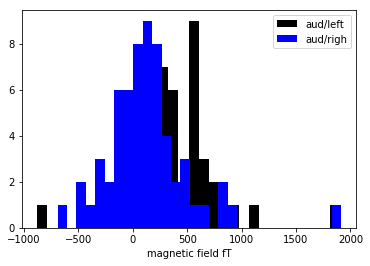

In [40]:
%matplotlib inline
plt.figure()
plt.hist(X_left, color='black', bins=30, label='aud/left')
plt.hist(X_right, color='blue', bins=30, label='aud/righ');
plt.legend(loc='best')
plt.xlabel('magnetic field fT')

In [41]:
t_obs = np.mean(X_left) - np.mean(X_right)
print(t_obs)

194.0527392739778


# Let's make a 2 sample permutation test

- Construct a null-distribution
- decide number of permutations
- for each permutation we permute the labels (condition 1 vs condition2)
- make big vector by concatenating X_left and X_right
- then we sample n_left samples and n_right after permuting a copy of the long vector
- and then recompute our test statistic (difference between condition means)
- make a histogram and plot together with observed value
- compute a p-value by counting the proportions of draws in which the test statistic under the null was greater than the observed test statistic
- take care of handling a two-sided test: either consider the absolute statistic or select the smaller p-value and multiply by two.
- take care of clipping zeros which may arise from insufficient numbers of permutations


# tips

- np.concatenate
- np.random.RandomState
- np.random.permutation

In [42]:
t_obs = np.mean(X_left) - np.mean(X_right)

x = np.concatenate((X_left, X_right))
n = len(x)
idx = np.arange(n)
n1 = len(X_left)
h0 = list()
rng = np.random.RandomState(seed=1)
n_perm = 5000
for ii in range(n_perm):
    idx_perm = rng.permutation(idx.copy())
    x_perm = x[idx_perm]
    t_obs_perm = np.mean(x_perm[:n1]) - np.mean(x_perm[n1:])
    h0.append(t_obs_perm)

# divide by 2 to avoid 1 sided test 

p_value = min(np.sum(h0 > t_obs) / len(h0),
              np.sum(h0 < -t_obs) / len(h0))

# correct for two tests
p_value *= 2

# clipping when no value was observed above observed statistic
p_value = max(p_value, 1 / n_perm)
print('Observed difference of means:', np.round(t_obs, 3), '[fT]')
print('p <', p_value)

Observed difference of means: 194.053 [fT]
p < 0.0064


# let's simulate stability of p-values



In [44]:
def permutation_test(n_perm=500, random_state=42):
    x = np.concatenate((X_left, X_right))
    n = len(x)
    idx = np.arange(n)
    n1 = len(X_left)
    h0 = list()
    rng = np.random.RandomState(random_state)
    for ii in range(n_perm):
        idx_perm = rng.permutation(idx.copy())
        x_perm = x[idx_perm]
        t_obs = np.mean(x_perm[:n1]) - np.mean(x_perm[n1:])
        h0.append(t_obs)
    return np.array(h0)

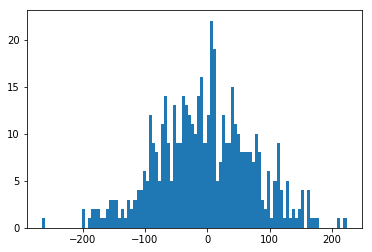

In [49]:
h0500 = permutation_test(n_perm=500, random_state=200)
plt.hist(h0500, bins=100);

In [73]:
def compute_p(h0, t_obs):
    p_value = np.mean(np.abs(h0) > np.abs(t_obs))
    # clipping when no value was observed above observed statistic
    p_value = max(p_value, 1 / len(h0))
    return p_value

In [74]:
permutation_range = np.arange(50, 10000, 20)
rng2 = np.random.RandomState(1)
seeds = rng2.randint(0, 1000, size=5)

In [75]:
p_vals = np.array(
    [[compute_p(permutation_test(
                n_perm=n_perm, random_state=seed), t_obs)
      for n_perm in permutation_range] for seed in seeds])

Text(0, 0.5, 'p-value')

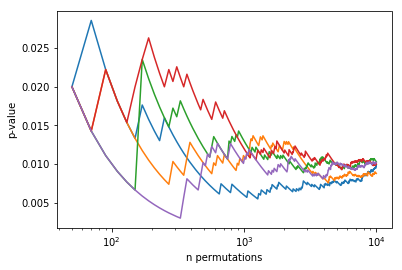

In [76]:
plt.figure()
plt.semilogx(permutation_range, p_vals.T)
plt.xlabel('n permutations')
plt.ylabel('p-value')
# plt.ylim(0, 0.1)

# Nonparametric Bootstrap

- prepare for 2000 iterations
- in each iteration, sample with replacement and randomly a subset of condition 1 and a second subset of condition 2 (2 draws 1 for each).
- compute the t_obs for that bootstrap replica and save it
- make a histogram that displays the t_obs* distributio and the initial t_obs
- draw the 5% and the 95% confidence intervals on the histogram

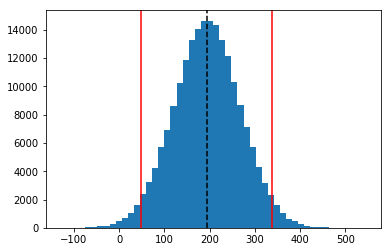

In [89]:
n_boots = 2000
bootstraps = list()
rng3 = np.random.RandomState(12)
for _ in range(200000):
    this_X_left = rng3.choice(
        X_left, size=len(X_left), replace=True)
    this_X_right = rng3.choice(
        X_right, size=len(X_right), replace=True)
    bootstraps.append(
        this_X_left.mean() - this_X_right.mean()
    )

plt.hist(bootstraps, bins=50)
plt.axvline(t_obs, color='black', linestyle='--')
ci_5, ci_95 = np.percentile(bootstraps, (2.5, 97.5)).T
plt.axvline(ci_5, color='red')
plt.axvline(ci_95, color='red')    

In [90]:
print("the bias is %0.3f" % (np.mean(bootstraps) - t_obs))

the bias is 0.113
